In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import seaborn as sns

In [2]:
#by hand, runs faster
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

#pythonic alternative (however: slower) to do the same thing:
def compute_return_2(df, r_type="log", h=1):
    
    if r_type == "log":
        return (np.log(df) - np.log(df.shift(h))) * 100
    else:
        return ((df-df.shift(h))/df) * 100 

In [3]:
import yfinance as yf

msft = yf.Ticker("^GDAXI")

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
hist = msft.history(period="max")

In [5]:
for i in range(5):
    hist["ret"+str(i+1)] = compute_return(hist["Close"].values, h=i+1)

In [6]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ret1,ret2,ret3,ret4,ret5
Date,,,,,,,,,,,,
2023-11-13 00:00:00+01:00,15285.120117,15346.790039,15252.269531,15345.000000,65170400,0.0,0.0,0.723434,-0.049125,0.754881,1.261494,1.371568
2023-11-14 00:00:00+01:00,15358.589844,15632.440430,15337.599609,15614.429688,98894400,0.0,0.0,1.740578,2.464012,1.691453,2.495459,3.002072
2023-11-15 00:00:00+01:00,15631.669922,15759.839844,15628.190430,15748.169922,91670700,0.0,0.0,0.852870,2.593448,3.316881,2.544323,3.348329
2023-11-16 00:00:00+01:00,15806.910156,15862.089844,15783.509766,15786.610352,68438900,0.0,0.0,0.243797,1.096667,2.837245,3.560679,2.788120
2023-11-17 00:00:00+01:00,15828.780273,15952.450195,15826.669922,15919.160156,81125800,0.0,0.0,0.836129,1.079926,1.932796,3.673374,4.396808


In [7]:
#quantile levels
tau = [.025, .25, .5, .75, .975]

In [8]:
#define prediction array
#cols are quantile levels, rows are horizons
pred_baseline = np.zeros((5,5))

In [9]:
last_t = 1000

for i in range(5):
    ret_str = "ret"+str(i+1)
    
    pred_baseline[i,:] = np.quantile(hist[ret_str].iloc[-last_t:], q=tau)

Visualize the results

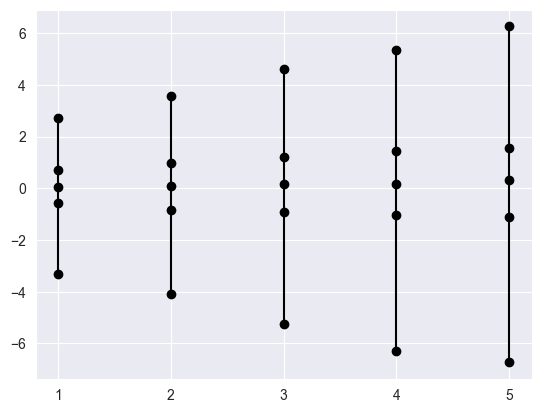

In [10]:
x = np.arange(5)+1
_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

Create Submission DataFrame

In [11]:
# Returns the five next working days as string
def get_forecast_dates(most_recent_date):
    working_days = []
    current_date = most_recent_date

    while len(working_days) < 5:
        # Increment the current date by one day
        current_date += timedelta(days=1)

        # Check if the current date is a working day (Monday to Friday)
        if current_date.weekday() < 5:
            working_days.append(current_date.date().strftime('%Y-%m-%d'))

    return working_days
        

In [12]:
df_sub = pd.DataFrame({
    "forecast_date": get_forecast_dates(max(hist.index)),
    "target": "DAX",
    "horizon": [str(i) + " day" for i in (1,2,5,6,7)],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]})
df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-20,DAX,1 day,-3.321265,-0.551383,0.060969,0.720873,2.719772
1,2023-11-21,DAX,2 day,-4.087895,-0.823250,0.072355,0.987420,3.570492
2,2023-11-22,DAX,5 day,-5.259161,-0.917655,0.161798,1.224285,4.628697
3,2023-11-23,DAX,6 day,-6.282629,-1.044070,0.186070,1.440815,5.367396
4,2023-11-24,DAX,7 day,-6.735742,-1.091646,0.326190,1.573729,6.259934


In [13]:
from DAX.Models.baseline import baseline

baseline(hist)

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-20,DAX,1 day,-3.321265,-0.551383,0.060969,0.720873,2.719772
1,2023-11-21,DAX,2 day,-4.087895,-0.823250,0.072355,0.987420,3.570492
2,2023-11-22,DAX,5 day,-5.259161,-0.917655,0.161798,1.224285,4.628697
3,2023-11-23,DAX,6 day,-6.282629,-1.044070,0.186070,1.440815,5.367396
4,2023-11-24,DAX,7 day,-6.735742,-1.091646,0.326190,1.573729,6.259934
